In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from utils.pareto_optimal import *
from utils.visualization import *
import seaborn as sns

# Partie 1 : Résultats préliminaires
Dans cette première partie nous avons implémenté et comparé plusieurs méthodes permettant de calculer a partir d'un ensemble d'images de points sur l'espace des objectifs l'ensemble des points efficaces.


## Génération des points

Pour commencer il s'agira d'abord de disposer d'un moyen simple de générer un nombre arbitraire de points dans l'espace des objectifs, pour se faire nous nous sommes appuyés sur la librarie numpy pour la génération des points et sur matplotlib pour les afficher.

Voici un nuage de points correspondant a 100 points tirés avec une moyenne de $1000$ et une variance de $\frac{1000}{3}$

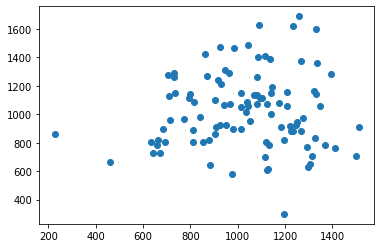

In [24]:
v = tirer(1000,100)
plt.scatter(v[:,0],v[:,1])

## Implémentation des algorithmes de determination des points efficaces

### Une approche (très) naive : 
La première approche a laquelle nous allons recourir consiste a déterminer pour chaque élément si il existe un élément le dominant sur les deux critères systématiquement.
Pour le faire sans utiliser de doubles boucles on va encore une fois s'appuyer sur les tableaux numpy, et ainsi pour chaque vecteur de coût *c* il suffit de vérifier : 
```
np.all(np.any(cout[:i]>c, axis=1)) et np.all(np.any(cout[i+1:]>c, axis=1))) 
```
ce qui coûte de passer par tout les autres coûts a chaque fois.


Dans la cellule suivante nous allons afficher le résultat de la procédure sur le nuage de points précédent : 

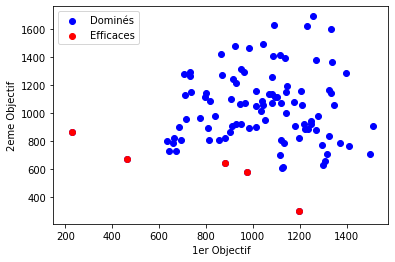

In [26]:
front = pareto_optimal_naif(v)
plot_front(v,front)

## Une approche un peu moins naive : 
La deuxième idée que l'on a eu consiste cette fois a éviter de ne tester chaque nouvel élément que avec les points non dominés jusque la, ceci se fait en maintenant un "masque" qui est un vecteur booléen ou chaque case a pour valeur Vrai si l'élément est efficace, initialement tous les éléments sont efficaces puis on met a jour un élément efficace de coût c comme avec la valeur suivante : 
```
np.any(couts[Efficace]<c, axis=1)
```

## Utiliser un tri 
Dans cet algorithme nous avons combiné un tri avec un parcours unique afin de générer l'ensemble de points efficaces, l'idée étant que dans la mesure ou le premier objectif progresse dans un ordre croissant, en maintenant la valeur minimale du deuxième objectif a chaque fois qu'on croise un élément dont le deuxième objectif est plus grand que le minimum on peut le retirer.

## Combiner un tri avec une aggrégation
Enfin la dernière astuce que nous avons considérés consiste simplement a trier les éléments du tableau en fonction de la somme des deux composantes avant de les donner a l'algorithme 2.
Cette astuce a été guidée par le fait que les opérations matricielles sont hautement paralélisables sur Numpy et donc assez efficaces.

# Test de fonctionnement
Afin de vérifier le fonctionnement de tous les algorithmes implémentés nous avons préparé un test unitaire, ce test consiste a charger automatiquement toutes les fonctions contenant dans leur nom de le mot "pareto" puis les exécuter sur le même nuage de 5000 points puis a comparer les retours des fonctions deux a deux.

In [4]:
!python utils/te.py

E
ERROR: test_prog_solving (__main__.TestSum)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "utils/te.py", line 36, in test_prog_solving
    f,g = test_dynamic_prog(5,2)
TypeError: test_dynamic_prog() missing 1 required positional argument: 'c'

----------------------------------------------------------------------
Ran 1 test in 0.000s

FAILED (errors=1)


# Test de performances
Dans cette partie nous avons comparés les temps d'éxécution des différents algorithmes, le protocole adopté pour mesurer l'évolution de la complexité en fonction du nombre de point consiste a exécuter les algorithmes sur des ensembles de points générés aléatoirement puis a mesurer le temps d'exécution observé.

Pour chaque nombre de points entre 100 et 10000 l'expérience a été répétée 50 fois, la courbe foncée représente la moyenne pour chaque taille et l'espace claire délimite l'intervalle de confiance.

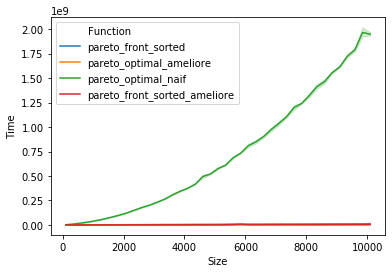

In [33]:
conc = []
for func in [pareto_front_sorted, pareto_optimal_ameliore, pareto_optimal_naif, pareto_front_sorted_ameliore]:
    Logs = stress_test_conf(func, lower_born= 100, upper_born=10000, step = 250, loc=1000, nb_trys = 50)
    df = pd.DataFrame(Logs)
    arr = np.array(df)
    conc = conc + list(arr)
conc = np.array(conc)
logs = pd.DataFrame(conc)
logs.columns  = ["Size", "Time", "Function"]
logs.Size = logs.Size.astype('float64')
logs.Time = logs.Time.astype('float64')
sns.lineplot(x="Size", y="Time", hue="Function",data=logs)


Première chose qu'on constate, la différence de complexité entre l'approche naive et les autres approches,
Pour bien se rendre compte de cette différence on peut faire passer le graphique a l'échelle log-log.

In [38]:
logs_echelle_log = logs

In [39]:
logs_echelle_log["Time"] = logs_echelle_log["Time"].apply(np.log)
logs_echelle_log["Size"] = logs_echelle_log["Size"].apply(np.log)


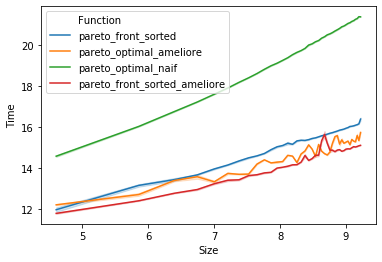

In [40]:
sns.lineplot(x="Size", y="Time", hue="Function",data=logs_echelle_log)

On remarque aisément la différence prononcée de pente entre l'approche naive et le reste des approche qui sont plus distinguables en utilisant cette echelle.
On peut d'ailleurs effectuer une regression linéaire sur cette echelle pour déterminer de façon approchée la complexité de chaque approche.


In [56]:
def fit_pol_func(func_name):
    df = logs_echelle_log[logs_echelle_log["Function"]==func_name]
    y = np.array(df["Time"])
    x = np.array(df["Size"])
    v = np.polyfit(x, y, 1)
    return v

In [59]:
for func in [pareto_front_sorted, pareto_optimal_ameliore, pareto_optimal_naif, pareto_front_sorted_ameliore]:
    print("Fonction name : ",func.__name__)
    v = fit_pol_func(func.__name__)
    print("Complexité : {:.0f}*X^{:.2f}".format(np.exp(v[1]) , v[0]))

Fonction name :  pareto_front_sorted
Complexité : 1765*X^0.94
Fonction name :  pareto_optimal_ameliore
Complexité : 3584*X^0.78
Fonction name :  pareto_optimal_naif
Complexité : 818*X^1.58
Fonction name :  pareto_front_sorted_ameliore
Complexité : 1901*X^0.82


A partir de la formule $log(t) \approx A log(x) + B$ nous pouvons déduire en repassant a l'echelle polynomiale : $t \approx exp(B)*X^A$
Donc comme on peut déduire les complexités suivantes : 
- **Algorithme naif** : $818*x^{1.58} = O(x²)$
- **Algorithme naif amélioré** : $3584*x^{0.78} = O(x)$
- **Algorithme avec Tri** : $1765*x^{0.94} = O(x)$
- **Algorithme avec Tri des valeurs aggrégées** : $1901*x^{0.82} = O(x)$

# Partie 2 : Procédure de résolution par programmation dynamique

In [783]:
n = 5
k = 4
get_random_cost = lambda  : np.abs(np.random.normal(0,100,(2,n)).astype(int))
get_random_bag = lambda  : np.random.randint(0,2,(n,1))

c = get_random_cost()

get_cost = lambda x,c : (c@x).T.flatten()


def get_cost_item_ids(xs,c):
    v= np.zeros((n,1))
    for x in xs:
        v[x-1] = 1
    return (v,c@v.reshape((-1)))

def get_cost_item_msq(v,c):
    return c@v.reshape((-1))

def pf(costs):
    or_costs = costs
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1

    is_efficient_mask = np.zeros(n_points, dtype = bool)
    is_efficient_mask[is_efficient] = True

    return is_efficient+1,is_efficient_mask,  or_costs[is_efficient_mask, :]


In [784]:
class Bag():

    def __init__(self,ids=[]):
        self.cost = (0,0)
        self.ids = []
        self.msq = np.zeros(n)
        self.set_ids(ids)
    
    def set_ids(self, ids):
        ids = sorted(ids)
        v,m = get_cost_item_ids(ids,c)
        self.cost = m
        self.msq = v
        self.ids = ids
    
    def add_item(self,id):
        L = list(self.ids)
        if not id in self.ids:
            L.append(id)
        self.ids = np.array(L)
        self.set_ids(self.ids)

    def __str__(self):
        return f"{self.ids} : {self.cost}"

    def set_msq(self,msq):
        self.ids = np.where(msq == 1)[0] + 1
        self.set_ids(self.ids)
    
    def __add__(self,b2):
        s = Bag([])
        id_u = list(self.ids) + list(b2.ids)
        id_u = set(id_u)
        id_u = list(id_u)
        s.set_ids(id_u)
        return s




    

In [788]:
B = Bag([0,1,2])
print(B)
v = np.zeros(n)
v[0] = 1
v[1] = 1
B2 = Bag([])
B2.set_msq(v)
print(B2)
print(B + B2)

[0, 1, 2] : [202. 427.]
[1, 2] : [191. 281.]
[0, 1, 2] : [202. 427.]


In [789]:
c

array([[129,  62, 117,  58,  11],
       [164, 117,  92,  13, 146]])

In [790]:
import copy
class Cell():
    def __init__(self):
        self.bags = []
        self.costs = []

    def add_bag(self, bag):
        bg = copy.deepcopy(bag)
        self.bags.append(bg)
        L = list(self.costs)
        L.append(bg.cost)
        self.costs = np.array(L) 
    
    def set_bag(self, bag):
        self.bags = []
        self.bags.append(bag)
        L = []
        L.append(bag.cost)
        self.costs = np.array(L)
    
    def __copy__(self):
        c = Cell()
        c.costs = np.copy(self.costs)
        c.bags = list(self.bags)

    
    def apply_pf(self):
        costs = np.array(self.costs)
        ids,msq ,c  = (pf(costs))
        self.bags = np.array(self.bags)[ids-1]
        self.costs = c
    
    def add_item_to_all(self,index):
        for b in self.bags:
            b.add_item(index)
        

    
    def __add__(self,cell):
        C = Cell()
        for b in cell.bags:
            C.add_bag(b)
        for b in self.bags:
            C.add_bag(b)
        return C

    
    def __str__(self):
        return "content : " + "\t".join([str(b) for b in self.bags])

In [791]:
import copy
C = Cell()
C.add_bag(B)
print(C)
C2 = copy.deepcopy(C)
C2.add_item_to_all(2)
C.add_item_to_all(1)
print(C2)
print(C)

content : [0, 1, 2] : [202. 427.]
content : [0, 1, 2] : [202. 427.]
content : [0, 1, 2] : [202. 427.]


In [792]:
C_sum = Cell()
for i in range(2):
    
    B = Bag()
    b = get_random_bag()
    B.set_msq(b)


    C = Cell()
    C.add_bag(B)
    print("C : ",C)
    C.add_item_to_all(3)
    print("C after adding 3: ",C)
    C_sum = C_sum +  C

print("C_sum : ",C_sum)
C_sum.apply_pf()
print("C_sum : ",C_sum)

C :  content : [2, 3, 4, 5] : [248. 368.]
C after adding 3:  content : [2, 3, 4, 5] : [248. 368.]
C :  content : [1, 3, 4, 5] : [315. 415.]
C after adding 3:  content : [1, 3, 4, 5] : [315. 415.]
C_sum :  content : [1, 3, 4, 5] : [315. 415.]	[2, 3, 4, 5] : [248. 368.]
C_sum :  content : [2, 3, 4, 5] : [248. 368.]


In [793]:
prog_table = [[ (Cell()) for x in range(n + 1)] for x in range(k + 1)]
prog_table = np.array(prog_table)
prog_table.shape

(5, 6)

In [794]:
obj = np.arange(1,n+1)
for i in range(1,n+1):
    bag = (pf(c.T[obj[:i] - 1])[0])
    print(i,bag)
    for b in bag:
        B = Bag([b])
        prog_table[1][i].add_bag(B)
    

1 [1]
2 [2]
3 [2 3]
4 [4]
5 [4 5]


In [795]:
def print_table(prog_table):
    for i in range(k+1):
        for j in range(n+1):
            print(f"[{i}, {j}] : ",prog_table[i][j])
print_table(prog_table)

[0, 0] :  content : 
[0, 1] :  content : 
[0, 2] :  content : 
[0, 3] :  content : 
[0, 4] :  content : 
[0, 5] :  content : 
[1, 0] :  content : 
[1, 1] :  content : [1] : [129. 164.]
[1, 2] :  content : [2] : [ 62. 117.]
[1, 3] :  content : [2] : [ 62. 117.]	[3] : [117.  92.]
[1, 4] :  content : [4] : [58. 13.]
[1, 5] :  content : [4] : [58. 13.]	[5] : [ 11. 146.]
[2, 0] :  content : 
[2, 1] :  content : 
[2, 2] :  content : 
[2, 3] :  content : 
[2, 4] :  content : 
[2, 5] :  content : 
[3, 0] :  content : 
[3, 1] :  content : 
[3, 2] :  content : 
[3, 3] :  content : 
[3, 4] :  content : 
[3, 5] :  content : 
[4, 0] :  content : 
[4, 1] :  content : 
[4, 2] :  content : 
[4, 3] :  content : 
[4, 4] :  content : 
[4, 5] :  content : 


In [796]:
for i in range(1,k+1):
    b= Bag(obj[:i])
    print(b)
    prog_table[i][i].set_bag(b)

[1] : [129. 164.]
[1, 2] : [191. 281.]
[1, 2, 3] : [308. 373.]
[1, 2, 3, 4] : [366. 386.]


In [797]:
print_table(prog_table)

[0, 0] :  content : 
[0, 1] :  content : 
[0, 2] :  content : 
[0, 3] :  content : 
[0, 4] :  content : 
[0, 5] :  content : 
[1, 0] :  content : 
[1, 1] :  content : [1] : [129. 164.]
[1, 2] :  content : [2] : [ 62. 117.]
[1, 3] :  content : [2] : [ 62. 117.]	[3] : [117.  92.]
[1, 4] :  content : [4] : [58. 13.]
[1, 5] :  content : [4] : [58. 13.]	[5] : [ 11. 146.]
[2, 0] :  content : 
[2, 1] :  content : 
[2, 2] :  content : [1, 2] : [191. 281.]
[2, 3] :  content : 
[2, 4] :  content : 
[2, 5] :  content : 
[3, 0] :  content : 
[3, 1] :  content : 
[3, 2] :  content : 
[3, 3] :  content : [1, 2, 3] : [308. 373.]
[3, 4] :  content : 
[3, 5] :  content : 
[4, 0] :  content : 
[4, 1] :  content : 
[4, 2] :  content : 
[4, 3] :  content : 
[4, 4] :  content : [1, 2, 3, 4] : [366. 386.]
[4, 5] :  content : 


In [798]:
prog_table = [[ (Cell()) for x in range(n + 1)] for x in range(k + 1)]
prog_table = np.array(prog_table)

obj = np.arange(1,n+1)
for i in range(1,n+1):
    bag = (pf(c.T[obj[:i] - 1])[0])
    print(i,bag)
    for b in bag:
        B = Bag([b])
        prog_table[1][i].add_bag(B)

for i in range(1,k+1):
    b= Bag(obj[:i])
    print(b)
    prog_table[i][i].set_bag(b)
    
for i in range(2,k+1):
    for j in range(3,n+1):
        if(j < i):
            continue
        print()
        print(f"In Cell [{i},{j}]")
        c1 = prog_table[i-1][j-1]
        c2 = prog_table[i][j-1]
        print(f"[{i-1},{j-1}] : ", c1)
        print(f"[{i},{j-1}] : ", c2)
        c3 = c1
        c3.add_item_to_all(j)
        c4 = c2 + c3
        print("The contenant before pf is : ",c4)
        c4.apply_pf()
        print(f"so the in  [{i},{j}] is : ",c4)
        prog_table[i][j] = c4
    

1 [1]
2 [2]
3 [2 3]
4 [4]
5 [4 5]
[1] : [129. 164.]
[1, 2] : [191. 281.]
[1, 2, 3] : [308. 373.]
[1, 2, 3, 4] : [366. 386.]

In Cell [2,3]
[1,2] :  content : [2] : [ 62. 117.]
[2,2] :  content : [1, 2] : [191. 281.]
The contenant before pf is :  content : [2, 3] : [179. 209.]	[1, 2] : [191. 281.]
so the in  [2,3] is :  content : [2, 3] : [179. 209.]

In Cell [2,4]
[1,3] :  content : [2] : [ 62. 117.]	[3] : [117.  92.]
[2,3] :  content : [2, 3] : [179. 209.]
The contenant before pf is :  content : [2, 4] : [120. 130.]	[3, 4] : [175. 105.]	[2, 3] : [179. 209.]
so the in  [2,4] is :  content : [2, 4] : [120. 130.]	[3, 4] : [175. 105.]

In Cell [2,5]
[1,4] :  content : [4] : [58. 13.]
[2,4] :  content : [2, 4] : [120. 130.]	[3, 4] : [175. 105.]
The contenant before pf is :  content : [4, 5] : [ 69. 159.]	[2, 4] : [120. 130.]	[3, 4] : [175. 105.]
so the in  [2,5] is :  content : [4, 5] : [ 69. 159.]	[2, 4] : [120. 130.]	[3, 4] : [175. 105.]

In Cell [3,3]
[2,2] :  content : [1, 2] : [191. 2

In [1]:
import copy
import numpy as np
from itertools import combinations

get_random_cost = lambda  n: np.abs(np.random.normal(0,100,(2,n)).astype(int))

def test_dynamic_prog(n,k):

    get_random_bag = lambda  : np.random.randint(0,2,(n,1))
    get_cost = lambda x,c : (c@x).T.flatten()

    def get_cost_item_ids(xs,c):
        v= np.zeros((n,1))
        for x in xs:
            v[x-1] = 1
        return (v,c@v.reshape((-1)))

    def get_cost_item_msq(v,c):
        return c@v.reshape((-1))

    def print_table(prog_table):
        for i in range(k+1):
            for j in range(n+1):
                print(f"[{i}, {j}] : ",prog_table[i][j])

    def pf(costs):
        or_costs = costs
        is_efficient = np.arange(costs.shape[0])
        n_points = costs.shape[0]
        next_point_index = 0
        while next_point_index<len(costs):
            nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
            nondominated_point_mask[next_point_index] = True
            is_efficient = is_efficient[nondominated_point_mask]
            costs = costs[nondominated_point_mask]
            next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1

        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True

        return is_efficient+1,is_efficient_mask,  or_costs[is_efficient_mask, :]

    class Bag():

        def __init__(self,ids=[]):
            self.cost = (0,0)
            self.ids = []
            self.msq = np.zeros(n)
            self.set_ids(ids)

        def set_ids(self, ids):
            ids = sorted(ids)
            v,m = get_cost_item_ids(ids,c)
            self.cost = m
            self.msq = v
            self.ids = ids

        def add_item(self,id):
            L = list(self.ids)
            if not id in self.ids:
                L.append(id)
            self.ids = np.array(L)
            self.set_ids(self.ids)

        def __str__(self):
            return f"{self.ids}"

        def set_msq(self,msq):
            self.ids = np.where(msq == 1)[0] + 1
            self.set_ids(self.ids)

        def __add__(self,b2):
            s = Bag([])
            id_u = list(self.ids) + list(b2.ids)
            id_u = set(id_u)
            id_u = list(id_u)
            s.set_ids(id_u)
            return s
        
        def __eq__(self, other):
            return sorted(self.ids) == sorted(other.ids)

    class Cell():
        def __init__(self):
            self.bags = []
            self.costs = []

        def add_bag(self, bag):
            bg = copy.deepcopy(bag)
            self.bags.append(bg)
            L = list(self.costs)
            L.append(bg.cost)
            self.costs = np.array(L) 

        def set_bag(self, bag):
            self.bags = []
            self.bags.append(bag)
            L = []
            L.append(bag.cost)
            self.costs = np.array(L)

        def __copy__(self):
            c = Cell()
            c.costs = np.copy(self.costs)
            c.bags = list(self.bags)


        def apply_pf(self):
            costs = np.array(self.costs)
            ids,msq ,c  = (pf(costs))
            self.bags = np.array(self.bags)[ids-1]
            self.costs = c
    
        def add_item_to_all(self,index):
           for b in self.bags:
               b.add_item(index)



        def __add__(self,cell):
           C = Cell()
           for b in cell.bags:
               C.add_bag(b)
           for b in self.bags:
               C.add_bag(b)
           return C
        
        def __eq__(self, other):
            if(len(self.bags) != len(other.bags)):
                return False

            for b1 in self.bags:
                if(b1 not in other.bags):
                    return False
            return True

    
        def __str__(self):
            return  "\t".join([str(b) for b in self.bags])
    
    def solve_exhaustif():

        i = combinations(np.arange(1,n+1),r = k)
        C = Cell()
        for j in i:
            b = Bag()
            b.set_ids(list(j))
            C.add_bag(b)
        #print(C)
        C.apply_pf()
        print(C)
        return C

    def solve_dynamic_programming():
        prog_table = [[ (Cell()) for x in range(n + 1)] for x in range(k + 1)]
        prog_table = np.array(prog_table)

        obj = np.arange(1,n+1)
        for i in range(1,n+1):
            bag = (pf(c.T[obj[:i] - 1])[0])
            #print(i,bag)
            for b in bag:
                B = Bag([b])
                prog_table[1][i].add_bag(B)

        for i in range(1,k+1):
            b= Bag(obj[:i])
            #print(b)
            prog_table[i][i].set_bag(b)

        for i in range(2,k+1):
            for j in range(3,n+1):
                if(j < i):
                    continue
                #print()
                #print(f"In Cell [{i},{j}]")
                c1 = prog_table[i-1][j-1]
                c2 = prog_table[i][j-1]
                #print(f"[{i-1},{j-1}] : ", c1)
                #print(f"[{i},{j-1}] : ", c2)
                c3 = c1
                c3.add_item_to_all(j)
                c4 = c2 + c3
                #print("The contenant before pf is : ",c4)
                c4.apply_pf()
                print(f"so the in  [{i},{j}] is : ",c4)
                prog_table[i][j] = c4
        return prog_table[k][n]



    return solve_dynamic_programming, solve_exhaustif
        


In [2]:
c = get_random_cost(5)
f,g = test_dynamic_prog(5,2)
c1 = f()

so the in  [2,3] is :  [1, 3]	[1, 2]
so the in  [2,4] is :  [1, 4]	[3, 4]	[1, 2]
so the in  [2,5] is :  [1, 4]	[3, 4]	[1, 2]


In [3]:
c2 = g()

[1, 2]	[1, 4]	[3, 4]


In [4]:
print(c2)
print(c1)
c1 == c2

[1, 2]	[1, 4]	[3, 4]
[1, 4]	[3, 4]	[1, 2]


True

In [1]:
from utils.dynamic_prog import *
c = get_random_cost(5)
f,g = test_dynamic_prog(5,2,c)
c1 = f()


so the in  [2,3] is :  [1, 3]	[2, 3]	[1, 2]
so the in  [2,4] is :  [1, 4]	[2, 4]	[3, 4]	[1, 2]
so the in  [2,5] is :  [1, 4]	[2, 4]	[3, 4]	[1, 2]


In [2]:
c2 = g()

[1, 2]	[1, 4]	[2, 4]	[3, 4]


In [3]:
c1 == c2 

True

In [812]:
c = get_random_cost()

prog_table = [[ (Cell()) for x in range(n + 1)] for x in range(k + 1)]
prog_table = np.array(prog_table)

obj = np.arange(1,n+1)
for i in range(1,n+1):
    bag = (pf(c.T[obj[:i] - 1])[0])
    print(i,bag)
    for b in bag:
        B = Bag([b])
        prog_table[1][i].add_bag(B)

for i in range(1,k+1):
    b= Bag(obj[:i])
    print(b)
    prog_table[i][i].set_bag(b)
    
for i in range(2,k+1):
    for j in range(3,n+1):
        if(j < i):
            continue
        print()
        print(f"In Cell [{i},{j}]")
        c1 = prog_table[i-1][j-1]
        c2 = prog_table[i][j-1]
        print(f"[{i-1},{j-1}] : ", c1)
        print(f"[{i},{j-1}] : ", c2)
        c3 = c1
        c3.add_item_to_all(j)
        c4 = c2 + c3
        print("The contenant before pf is : ",c4)
        c4.apply_pf()
        print(f"so the in  [{i},{j}] is : ",c4)
        prog_table[i][j] = c4
    

1 [1]
2 [1 2]
3 [1 2 3]
4 [1 2 3]
5 [1 3 5]
[1] : [81.  5.]
[1, 2] : [114. 113.]
[1, 2, 3] : [180. 170.]
[1, 2, 3, 4] : [231. 292.]

In Cell [2,3]
[1,2] :  content : [1] : [81.  5.]	[2] : [ 33. 108.]
[2,2] :  content : [1, 2] : [114. 113.]
The contenant before pf is :  content : [1, 3] : [147.  62.]	[2, 3] : [ 99. 165.]	[1, 2] : [114. 113.]
so the in  [2,3] is :  content : [1, 3] : [147.  62.]	[2, 3] : [ 99. 165.]	[1, 2] : [114. 113.]

In Cell [2,4]
[1,3] :  content : [1] : [81.  5.]	[2] : [ 33. 108.]	[3] : [66. 57.]
[2,3] :  content : [1, 3] : [147.  62.]	[2, 3] : [ 99. 165.]	[1, 2] : [114. 113.]
The contenant before pf is :  content : [1, 4] : [132. 127.]	[2, 4] : [ 84. 230.]	[3, 4] : [117. 179.]	[1, 3] : [147.  62.]	[2, 3] : [ 99. 165.]	[1, 2] : [114. 113.]
so the in  [2,4] is :  content : [2, 4] : [ 84. 230.]	[1, 3] : [147.  62.]	[2, 3] : [ 99. 165.]	[1, 2] : [114. 113.]

In Cell [2,5]
[1,4] :  content : [1] : [81.  5.]	[2] : [ 33. 108.]	[3] : [66. 57.]
[2,4] :  content : [2, 4] : 

In [813]:
from itertools import combinations

i = combinations(np.arange(1,n+1),r = k)
C = Cell()
for j in i:
    b = Bag()
    b.set_ids(list(j))
    C.add_bag(b)
print(C)
C.apply_pf()
print(C)

content : [1, 2, 3, 4] : [231. 292.]	[1, 2, 3, 5] : [201. 249.]	[1, 2, 4, 5] : [186. 314.]	[1, 3, 4, 5] : [219. 263.]	[2, 3, 4, 5] : [171. 366.]
content : [1, 2, 3, 5] : [201. 249.]	[1, 2, 4, 5] : [186. 314.]	[2, 3, 4, 5] : [171. 366.]
